Goal is to explore healthcare cost data and eventually build model to predict cost associated with a particular patient

Start by importing the required packages and loading the data


In [103]:
import numpy as np
import pandas as pd
import seaborn as sns

In [104]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Start by looking at basic info about the dataset

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [106]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Good to see that there is no missing data in this dataset. It is likely that this was done before the data was published on kaggle.

Let's start by looking at some distributions for the numerical variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2915d1d0>]],
      dtype=object)

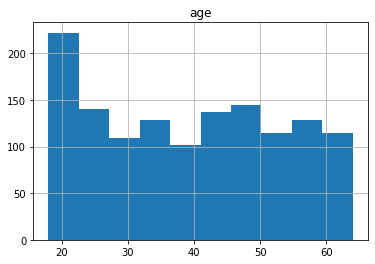

In [107]:
hist = df.hist(column = 'age')
hist

Highest number is in the youngest range and after that the distribution is pretty uniform

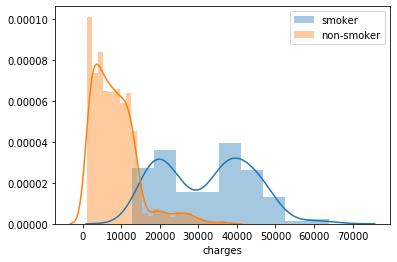

In [108]:
import matplotlib.pyplot as plt
sns.distplot(df[df['smoker'] == 'yes']["charges"], label = "smoker")
sns.distplot(df[df['smoker'] == 'no']["charges"], label = "non-smoker")
plt.legend()

It is evident that smokers have higher costs almost across the board. This is not very surprising. Next let's look at differences among males and females in a similar fashion

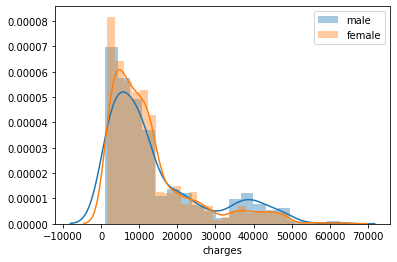

In [109]:
import matplotlib.pyplot as plt
sns.distplot(df[df['sex'] == 'male']["charges"], label = "male")
sns.distplot(df[df['sex'] == 'female']["charges"], label = "female")
plt.legend()

Men may have slightly higher costs but it isn't a very pronounced difference. However let's now look at the relationship between sex and smoking. Let's start by looking at the number of male and female smokers

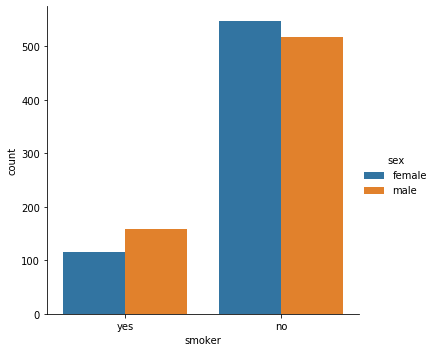

In [110]:
sns.catplot(x = 'smoker', kind = 'count', hue = 'sex', data = df)

More men smoke than females so that's likely where the trend we saw earlier is coming from. However it is not that drastic of a difference. To finish this off let's make four subplots of costs: male smokers, male non-smokers, female smokers, female non-smokers

Text(0.5, 1.0, 'Female Non-Smokers')

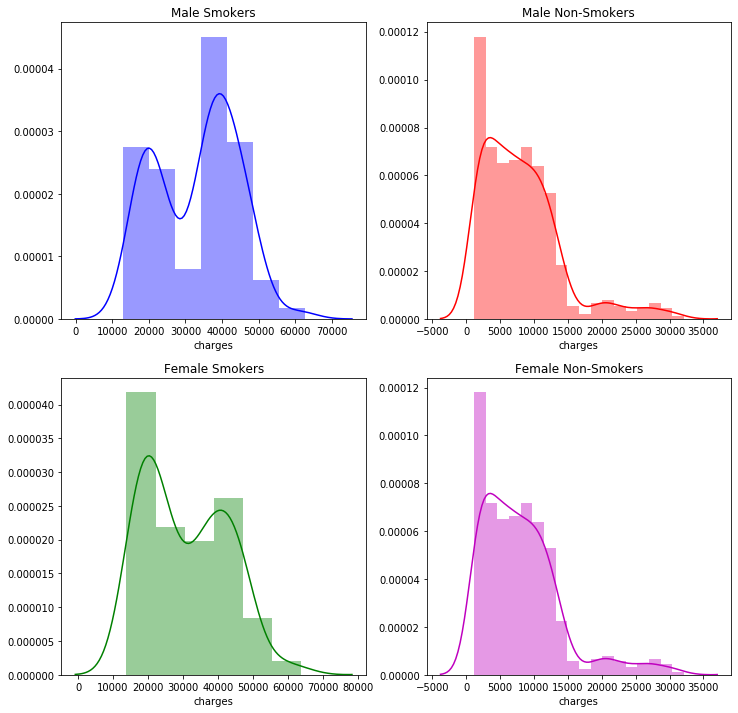

In [111]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))
#f.add_subplot(122)
sns.distplot(df[(df['sex'] == 'male') & (df['smoker'] == 'yes')]["charges"], label = "male smoker", ax=axes[0, 0], color = "b")
axes[0][0].set_title('Male Smokers')


#f.add_subplot(121)
sns.distplot(df[(df['sex'] == 'male') & (df['smoker'] == 'no')]["charges"], label = "male non-smoker", ax=axes[0, 1], color = "r")
axes[0][1].set_title('Male Non-Smokers')

#f.add_subplot(123)
sns.distplot(df[(df['sex'] == 'female') & (df['smoker'] == 'yes')]["charges"], label = "female smoker", ax=axes[1, 0], color = "g")
axes[1][0].set_title('Female Smokers')

#f.add_subplot(4)
sns.distplot(df[(df['sex'] == 'male') & (df['smoker'] == 'no')]["charges"], label = "female non-smoker", ax=axes[1, 1], color = "m")
axes[1][1].set_title('Female Non-Smokers')


Interestingly, for both male and female smokers we have bimodal distributions (which we saw in the general smokers plot as well), while that is not the case for the non-smokers. Also, overall male smokers are the highest paying group, followed by female smokers, and then the two groups of non-smokers don't show much difference

Let's now look at the BMI by first just plotting it's distribution

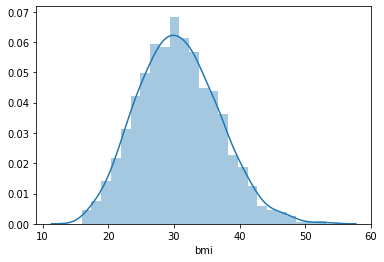

In [112]:
sns.distplot(df["bmi"], label = "male")

Data is representative of the population in that it is normally distributed around 30. My expectation is that there is a high cost associated with a low BMI and with a high BMI. However, to start let's calculate the correlation between BMI and cost.

In [113]:
df['charges'].corr(df['bmi'])

0.19834096883362892

There's a positive correlation however it isn't huge. Let's graph bmi on the x axis and charges on the y axis to see the relationship better.

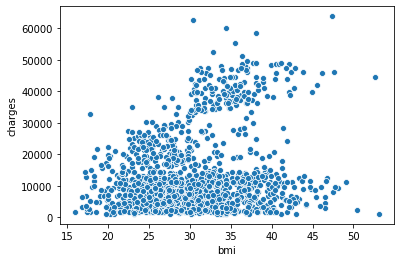

In [114]:
sns.scatterplot(x = df['bmi'], y = df['charges'])

The low bmi values do not lead to the high charge values that I expected. Additionally, there seem to be two "bands" of patients that start around the 30 bmi value. My first guess is that this is smokers and non-smokers so let's color the dots with that distinction.

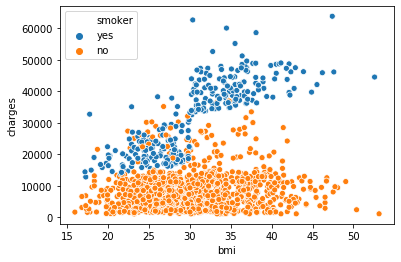

In [115]:
sns.scatterplot(x = df['bmi'], y = df['charges'], hue = df['smoker'])

This graphic is very revealing. For non-smokers BMI does not seem to matter much. However if you ARE a smoker, than there seems to be a fairly clear linear relationship between increasing BMI and increasing charges. Now, just to check that sex isn't involved here as well, let's create a similar graph with the hue based on sex.

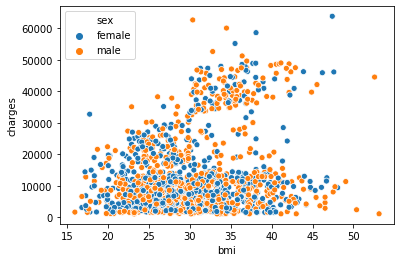

In [116]:
sns.scatterplot(x = df['bmi'], y = df['charges'], hue = df['sex'])

As expected the separation is not nearly as clear as it is when coloring based on smokers and non-smokers.

Next we can look at age. I expect to see a positive correlation between the age and the charges however let's confirm that.

In [117]:
df['charges'].corr(df['age'])

0.29900819333064765

And then with a scatter plot as well

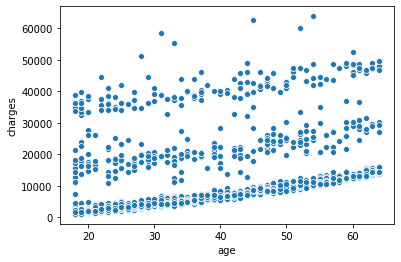

In [118]:
sns.scatterplot(x = df['age'], y = df['charges'])

We can visually see a linear relationship between the two variables however this time there are THREE bands of patients. Let's start with seeing how smoking plays a role.

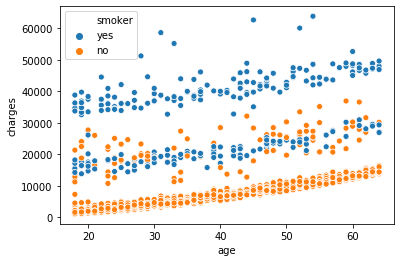

In [119]:
sns.scatterplot(x = df['age'], y = df['charges'], hue = df['smoker'])

Smoking easily explains the top and bottom bands but not the middle one.

For now it seems like the middle band is explained by other factors, likely a combination of bmi and sex. So we'll move on for now but may come back to this later.

We haven't yet looked at the "children" feature so let's start by looking at the counts for the number of children.

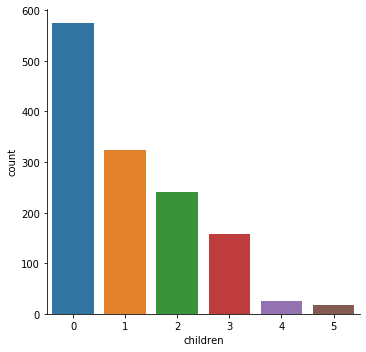

In [120]:
sns.catplot(x = 'children', kind = 'count', data = df)

As expected, having more and more children becomes less common in the population. Because of this, we'll have to be careful about how we use the data once we get to 4 or 5 children because of scarcity. To visualize, let's make box plots of the charges for each category of having children.

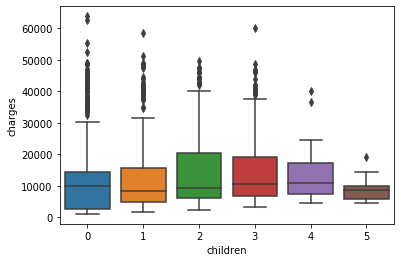

In [121]:
sns.boxplot(x = 'children', y = 'charges', data = df)

Difficult to see any real relationship between the variables. For numeric confirmation we can calculate the correlation as well.

In [122]:
df['charges'].corr(df['children'])

0.06799822684790487

As expected, the correlation is pretty weak. For now, we'll leave the children variable in. However, we will likely try a version of the model where the children feature is left out.

Last feature to look at on its own is the region. Similar to the children feature, let's first just look at some counts.

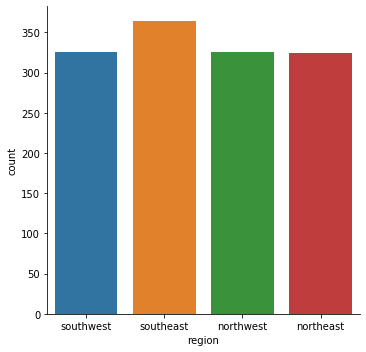

In [123]:
sns.catplot(x = 'region', kind = 'count', data = df)

No region outweighs the others which is good to see so let's once again go to the boxplot

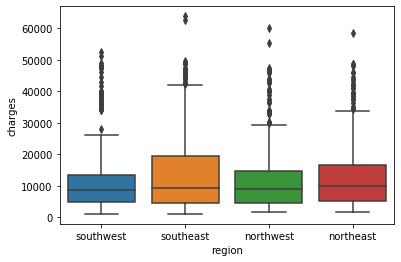

In [124]:
sns.boxplot(x = 'region', y = 'charges', data = df)

Similar to children, charges seem to not be affected much by the region

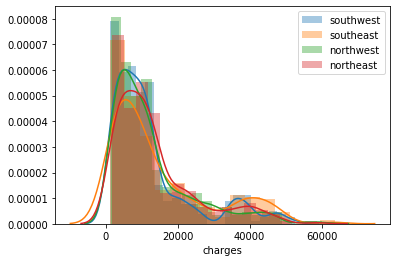

In [125]:
sns.distplot(df[df['region'] == 'southwest']["charges"], label = "southwest")
sns.distplot(df[df['region'] == 'southeast']["charges"], label = "southeast")
sns.distplot(df[df['region'] == 'northwest']["charges"], label = "northwest")
sns.distplot(df[df['region'] == 'northeast']["charges"], label = "northeast")
plt.legend()

Nothing distinguishable here either. To start we'll leave this in the model and just label encode it, however, we'll try a version without the feature as well.

To get the data ready for modeling, the features we need to turn into numerics are smoker, sex, and region.

In [126]:
df['smoker'] = np.where(df['smoker'] == 'yes', 1, 0)
df['sex'] = np.where(df['sex'] == 'male', 1, 0)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [127]:
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder()
df['region'] = labelencoder.fit_transform(df['region']) #use label encoder on the region
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


We now need to load the necessary libraries for modeling

In [128]:
import sklearn.model_selection as model_selection
from sklearn import ensemble

In [73]:
X = df.drop(columns = ['charges'])
y = df['charges']
[X_train, X_test, y_train, y_test] = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)
gradient_boosting_regressor = ensemble.GradientBoostingRegressor()
gradient_boosting_regressor.fit(X_train, y_train)
print(gradient_boosting_regressor.score(X_train, y_train))
y_test_predictions = gradient_boosting_regressor.predict(X_test)
print(gradient_boosting_regressor.score(X_test, y_test))

0.9134024649512867
0.8497655884867678


The above model is with the default GradientBoostingRegressor parameters, we now need to tune some of those. NOTE: CODE FOR TUNING COMES FROM https://shankarmsy.github.io/stories/gbrt-sklearn.html

In [89]:
def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(X_train.shape[0], test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

In [90]:
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn import metrics 
#from sklearn.learning_curve import learning_curve 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV

In [93]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [6,4,6],
            'min_samples_leaf':[3,5,9,17],
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [94]:
best_est

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [96]:
print( "Best Estimator Parameters" )
print("---------------------------" )
print ("n_estimators: %d" %best_est.n_estimators )
print ("max_depth: %d" %best_est.max_depth )
print ("Learning Rate: %.1f" %best_est.learning_rate )
print ("min_samples_leaf: %d" %best_est.min_samples_leaf )
print ("max_features: %.1f" %best_est.max_features )
print() 
print ("Train R-squared: %.2f" %best_est.score(X_train,y_train))

Best Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 4
Learning Rate: 0.1
min_samples_leaf: 17
max_features: 1.0

Train R-squared: 0.89


We now use these best fit parameters for the final model

In [99]:
gradient_boosting_regressor = ensemble.GradientBoostingRegressor(n_estimators = 100, max_depth = 4,
                                                                 learning_rate = 0.1, min_samples_leaf = 17,
                                                                  max_features = 1.0)
gradient_boosting_regressor.fit(X_train, y_train)
print(gradient_boosting_regressor.score(X_train, y_train))
y_test_predictions = gradient_boosting_regressor.predict(X_test)
print(gradient_boosting_regressor.score(X_test, y_test))

0.9068513089863962
0.8474168064531867


Text(0.5, 1.0, 'Feature Importance (MDI)')

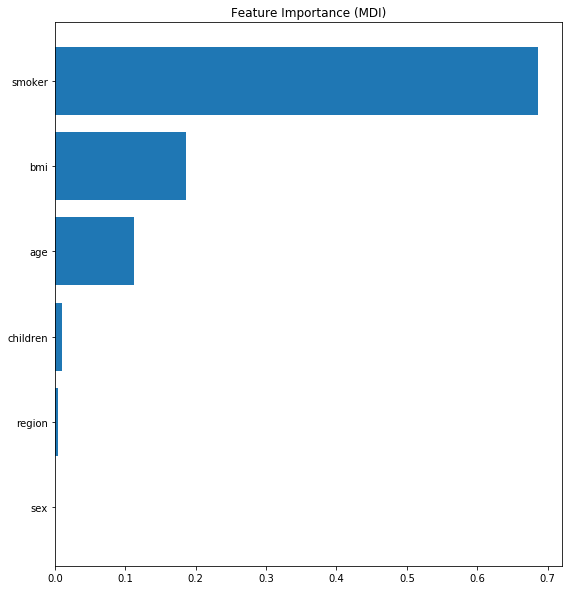

In [100]:
feature_importance = gradient_boosting_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

In [129]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['smoker', 'bmi', 'age', 'children', 'region', 'sex']])
df[['smoker', 'bmi', 'age', 'children', 'region', 'sex']] = scaler.transform(df[['smoker', 'bmi', 'age', 'children', 'region', 'sex']])
df.head()


,age,sex,bmi,children,smoker,region,charges
0,0.021739,0.0,0.321227,0.0,1.0,1.000000,16884.92400
1,0.000000,1.0,0.479150,0.2,0.0,0.666667,1725.55230
2,0.217391,1.0,0.458434,0.6,0.0,0.666667,4449.46200
3,0.326087,1.0,0.181464,0.0,0.0,0.333333,21984.47061
4,0.304348,1.0,0.347592,0.0,0.0,0.333333,3866.85520


array([[0.02173913, 0.        , 0.3212268 , ..., 1.        , 1.        ,
        0.25161076],
       [0.        , 1.        , 0.47914985, ..., 0.        , 0.66666667,
        0.00963595],
       [0.2173913 , 1.        , 0.45843422, ..., 0.        , 0.66666667,
        0.05311516],
       ...,
       [0.        , 0.        , 0.56201238, ..., 0.        , 0.66666667,
        0.00810808],
       [0.06521739, 0.        , 0.26472962, ..., 0.        , 1.        ,
        0.01414352],
       [0.93478261, 0.        , 0.35270379, ..., 1.        , 0.33333333,
        0.44724873]])

In [130]:
X = df.drop(columns = ['charges'])
y = df['charges']
[X_train, X_test, y_train, y_test] = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)
gradient_boosting_regressor = ensemble.GradientBoostingRegressor(n_estimators = 100, max_depth = 4,
                                                                 learning_rate = 0.1, min_samples_leaf = 17,
                                                                  max_features = 1.0)
gradient_boosting_regressor.fit(X_train, y_train)
print(gradient_boosting_regressor.score(X_train, y_train))
y_test_predictions = gradient_boosting_regressor.predict(X_test)
print(gradient_boosting_regressor.score(X_test, y_test))

0.9068513089863962
0.8474350119279035
